In [40]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
ml_hs_2017_all = pd.read_csv("https://github.com/jakemdrew/EducationDataNC/raw/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv")

# creating categorical variable from existing column - https://stackoverflow.com/a/49269107
ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] < 1150,'sat_high_level'] = 0
ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >= 1150,'sat_high_level'] = 1

# subsetting to remove rows where no average SAT score was reported
ml_hs_2017 = ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >0]

In [41]:
zero_counts = []
for column in ml_hs_2017:
    zero_counts.append({'Column': column, 'count': np.sum((ml_hs_2017[column]==0)), 'Percentage': np.sum((ml_hs_2017[column]==0)/len(ml_hs_2017))})

In [42]:
zero_counts = pd.DataFrame(zero_counts)
to_drop = zero_counts.loc[zero_counts['Percentage'] >= .999]
hs_2017 = ml_hs_2017.drop(to_drop['Column'], axis=1)

In [43]:
# derive the absolute pearson's r for correlation, convert to dataframe

abs_correlation_ml_final = hs_2017.corr(method='pearson').abs()
abs_correlation_ml_final = pd.DataFrame(abs_correlation_ml_final)

In [61]:
sat_correlation = abs_correlation_ml_final.sort_values(by='sat_high_level',ascending=False)
hs_2017_sat_high = sat_correlation.loc[sat_correlation['sat_high_level'] >= 0.25]

hs_2017 = hs_2017[['sat_high_level','sat_avg_score_num','ACTScience_ACTBenchmark_All','ACTMath_ACTBenchmark_All','ACTScience_ACTBenchmark_Female','ACTMath_ACTBenchmark_Female','ACTReading_ACTBenchmark_Female','ACTScience_ACTBenchmark_Male','ACTMath_ACTBenchmark_Male','ACTScience_ACTBenchmark_White','ACTEnglish_ACTBenchmark_Female','ACTMath_ACTBenchmark_White','Gr_9_Pct_Prof','ACT Score','ACTWriting_ACTBenchmark_All','ACTSubtests_BenchmarksMet_White','EOCSubjects_CACR_All','ACTCompositeScore_UNCMin_Female','EOCMathI_CACR_Male','SPG Score','pct_eds','ACTSubtests_BenchmarksMet_AIG','ACTCompositeScore_UNCMin_Male','EOCEnglish2_CACR_Male','ACTWriting_ACTBenchmark_White','EOCMathI_CACR_White','ACTWriting_ACTBenchmark_Male','EOCSubjects_CACR_White','EOCEnglish2_CACR_Female','NC Math 1 Score','lea_sat_avg_score_num','ACTSubtests_BenchmarksMet_EDS','EOCBiology_CACR_Female','English II Score','ACTScience_ACTBenchmark_AIG','EOCEnglish2_CACR_White','ACTCompositeScore_UNCMin_White','lea_ap_pct_3_or_above','ACTSubtests_BenchmarksMet_Hispanic','EOCBiology_CACR_Male','Biology Score','EOCSubjects_CACR_Hispanic','ACTScience_ACTBenchmark_EDS','ACTSubtests_BenchmarksMet_Asian','ACTSubtests_BenchmarksMet_TwoorMoreRaces','EOCSubjects_CACR_EDS','EOCBiology_CACR_White','4-Year Cohort Graduation Rate Score','ACTReading_ACTBenchmark_EDS','ACTWriting_ACTBenchmark_AIG','ACTMath_ACTBenchmark_EDS','EOCMathI_CACR_EDS','ACTSubtests_BenchmarksMet_Black','ap_pct_3_or_above','ACTMath_ACTBenchmark_AIG','ACTWriting_ACTBenchmark_EDS','EOCBiology_CACR_Asian','ap_participation_pct','ACTWriting_ACTBenchmark_Asian','MW_White_ENROLL_sch_pct','ACTSubtests_BenchmarksMet_SWD','ACTCompositeScore_UNCMin_Asian','BlackPct','EOCEnglish2_CACR_Asian','SPG Grade_C','lateral_teach_pct','AsianFemalePct','short_susp_per_c_num','BlackMalePct','advance_dgr_pct','ACTEnglish_ACTBenchmark_EDS','flicensed_teach_pct','lea_nbpts_num','avg_daily_attend_pct','EOCMathI_CACR_Asian','EOCEnglish2_CACR_EDS','Proficient_TCHR_Standard 4_Pct','lea_federal_perpupil_num','nbpts_num','lea_ap_participation_pct','MinorityMalePct','ACTCompositeScore_UNCMin_EDS','MinorityPct','cte_courses','AsianMalePct','EOCSubjects_CACR_Asian','ACTScience_ACTBenchmark_Black','BlackFemalePct','ACTReading_ACTBenchmark_SWD','ACTScience_ACTBenchmark_Hispanic','lea_advance_dgr_pct','ACTMath_ACTBenchmark_SWD','GraduationRate_4yr_Asian','GraduationRate_5yr_Asian','ACTScience_ACTBenchmark_SWD','Does Not Meet Expected Growth_TCHR_Student Growth_Pct','ACTEnglish_ACTBenchmark_SWD','Proficient_TCHR_Standard 1_Pct','Proficient_TCHR_Standard 2_Pct','lea_salary_expense_pct','ACTCompositeScore_UNCMin_SWD','ACTWriting_ACTBenchmark_Hispanic','ACTMath_ACTBenchmark_Hispanic','Proficient_TCHR_Standard 5_Pct','lea_short_susp_per_c_num','ACTScience_ACTBenchmark_TwoorMoreRaces','State Gap Compared_Y','ACTMath_ACTBenchmark_TwoorMoreRaces','lea_flicensed_teach_pct','ACTReading_ACTBenchmark_Hispanic','MB_Black_ENROLL_sch_pct','lea_supplies_expense_pct','Exceeds Expected Growth_TCHR_Student Growth_Pct','Proficient_TCHR_Standard 3_Pct','ACTMath_ACTBenchmark_Black','EOCMathI_CACR_Hispanic','GraduationRate_4yr_Male','M_Male_ENROLL_sch_pct','lea_local_perpupil_num','EOCBiology_CACR_EDS','tchyrs_0thru3_pct','Accomplished_TCHR_Standard 4_Pct','ACTEnglish_ACTBenchmark_Hispanic','MinorityFemalePct','Accomplished_TCHR_Standard 5_Pct','ACTWriting_ACTBenchmark_SWD','Accomplished_TCHR_Standard 2_Pct']]
hs_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 469
Columns: 127 entries, sat_high_level to Accomplished_TCHR_Standard 2_Pct
dtypes: float64(125), int64(2)
memory usage: 441.0 KB


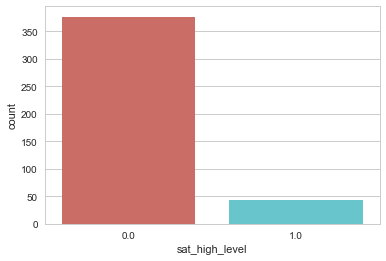

In [62]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='sat_high_level',data=hs_2017, palette='hls')
plt.show()

In [63]:
X = hs_2017.iloc[:,1:]
y = hs_2017.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [64]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[72  1]
 [ 4  8]]


In [66]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94
